# H&M Recommendations Challenge

The data can be loaded into a neo4j database using this [script](load_hm_data.cql)

## Exploratory Analysis

In [197]:
import pandas as pd
import numpy as np
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

Firstly, let's get an idea of the number of some summary statistics such as number of customers, number of products and average number of purchases

In [4]:
with driver.session() as session:
    query = """
    MATCH (c:Customer)
    RETURN 'Customer' as Label, COUNT(c) as total_count
    UNION
    MATCH (p:Product)
    RETURN 'Product' as Label, COUNT(p) as total_count
    UNION
    MATCH (c:Customer)-[pur:PURCHASED]->(p:Product)
    RETURN 'Purchases' as Label, COUNT(pur) as total_count
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])
    
    

In [5]:
df

,Label,total_count
0,Customer,1371980
1,Product,105542
2,Purchases,28813419


Now we have an idea of the number of user, products and purchases, we can look some other summary statistics such as the average number of purchases per user and the average number of times each item has been purchased

In [7]:
with driver.session() as session:
    query = """
    MATCH (c:Customer)-[pur:PURCHASED]->(p:Product)
    WITH c, COUNT(pur) AS num_purchases
    RETURN 'Customer Purchases' as Label, AVG(num_purchases) as avg, stDevP(num_purchases) as std_dev
    UNION
    MATCH (p:Product)<-[pur:PURCHASED]-(c:Customer)
    WITH p, COUNT(pur) AS times_purchased
    RETURN 'Product Purchased' as Label, AVG(times_purchased) as avg, stDevP(times_purchased) as std_dev
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])

In [9]:
df.round(2)

,Label,avg,std_dev
0,Customer Purchases,21.15,34.59
1,Product Purchased,275.60,696.87


And now we can see the summary stats for purchases with an average of just over 21 purchases per customer, albeit with a large standard deviation anf each item purchases on average 275 times with a huge standard deviation. Looking at the stats I would assume the data is heavily skewed so we can visualise it to find out

In [20]:
with driver.session() as session:
    query = """
    MATCH (c:Customer)-[pur:PURCHASED]->(p:Product)
    WITH c, COUNT(pur) AS num_purchases
    RETURN collect(num_purchases) as purchases
    UNION
    MATCH (p:Product)<-[pur:PURCHASED]-(c:Customer)
    WITH p, COUNT(pur) AS times_purchased
    RETURN collect(times_purchased) as purchases 
    """
    
    data = list(session.run(query))
    
customer_purchases = data[0][0]
product_purchases = data[1][0]

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

<AxesSubplot:title={'center':'Distribution of number of times item purchased'}, ylabel='Density'>

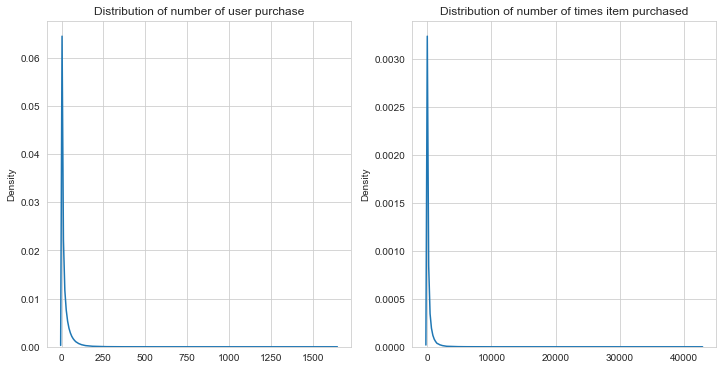

In [41]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,6), ncols=2)
ax1.set_title('Distribution of number of user purchase')
ax2.set_title('Distribution of number of times item purchased')
sns.kdeplot(customer_purchases, ax = ax1)
sns.kdeplot(product_purchases, ax = ax2)

As we can see, the data is massively right skewed meaning we have a small number of users that purchases lots of items with lots of users who purchase only a smaller number of items in comparison and the same for the product distribution. The data model also includes a number of properties relating to the product type so lets explore these next.

In [149]:
with driver.session() as session:
    query = """
    MATCH (p:Product)-[:SUBSET_OF]->(n:ProductType) RETURN n.name as product_type, COUNT(p) as count
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])

In [152]:
# Save the bestselling product types for later
bestsellers = df.sort_values('count', ascending=False).head(30)['product_type']

<AxesSubplot:xlabel='count', ylabel='product_type'>

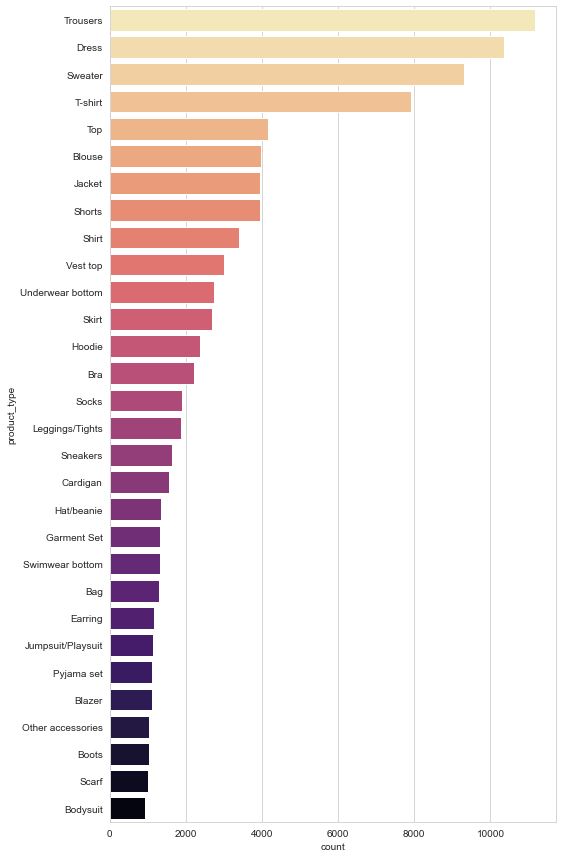

In [150]:
# Let's have a look at the top 30 types of item
plt.figure(figsize = (8,15))
sns.barplot(
    x='count', 
    y='product_type', 
    data=df.sort_values('count', ascending=False).head(30), 
    palette='magma_r',
)

In [68]:
with driver.session() as session:
    query = """
    MATCH (p:Product)-[:HAS_GARMENT_GROUP]->(g:GarmentGroup) RETURN g.name as garment_group, COUNT(g) as count
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])

<AxesSubplot:xlabel='count', ylabel='garment_group'>

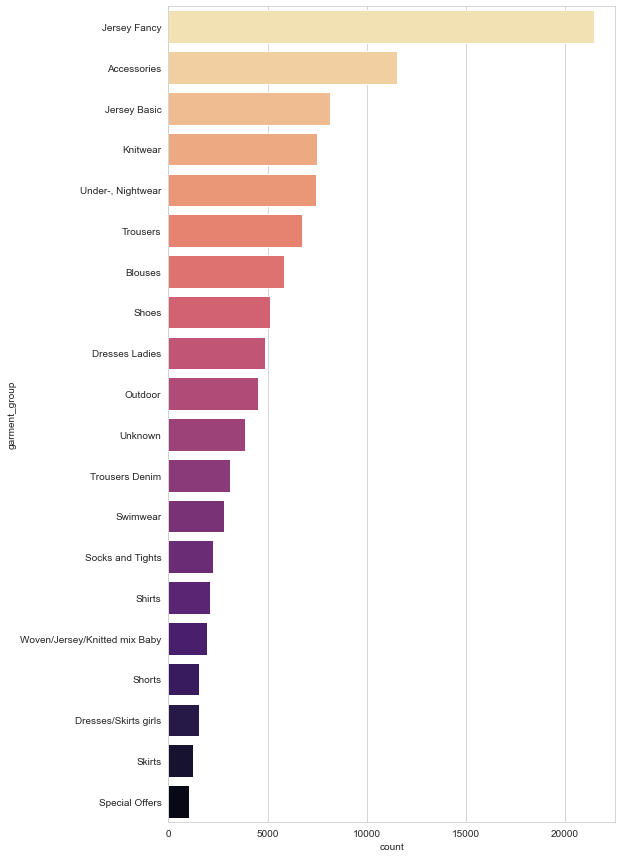

In [69]:
plt.figure(figsize = (8,15))
sns.barplot(
    x='count', 
    y='garment_group', 
    data=df.sort_values('count', ascending=False).head(20), 
    palette='magma_r'
)

One aspect we haven't touched on so far is the temporal nature of purchases. Firstly, let's see how the number all purchases varies on a daily, weekly and monthly basis



In [80]:
with driver.session() as session:

    query = """
    MATCH ()-[p:PURCHASED]-()
    RETURN p.t_date as date, COUNT(p) as num_purchases
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])


In [108]:
# Convert neo4j.dates to python datetimes
import datetime as dt
df['date'] = df['date'].apply(lambda x: dt.date(x.year, x.month, x.day))
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

<AxesSubplot:xlabel='date', ylabel='num_purchases'>

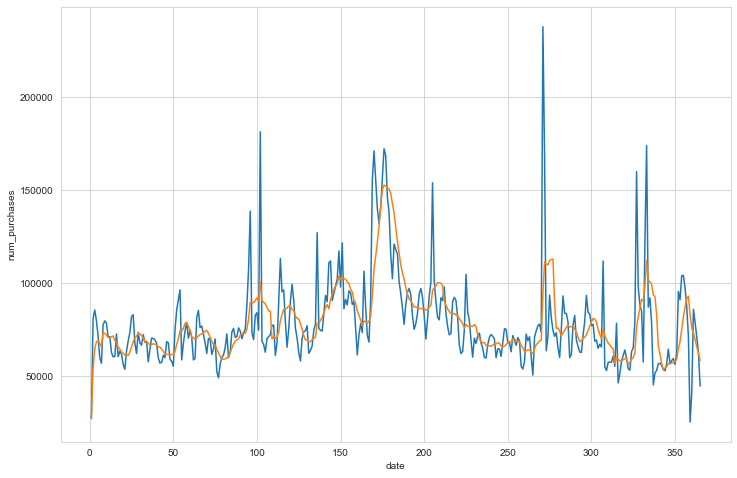

In [133]:
daily_counts = df.groupby(df.index.dayofyear).mean()

plt.figure(figsize = (12,8))
sns.lineplot(
    x=daily_counts.index, 
    y='num_purchases', 
    data=daily_counts,
    palette='mako'
)
sns.lineplot(
    x=daily_counts.index, 
    y='num_purchases', 
    data=daily_counts.rolling(7, min_periods=1).mean(),
    palette='mako'
)

The next question to answer is does this seasonaility vary depending on the type of product being purchased?

In [165]:
with driver.session() as session:
    query = """
    MATCH ()-[pur:PURCHASED]->(p:Product)-[:SUBSET_OF]->(n:ProductType) RETURN pur.t_date as date, n.name as product_type, COUNT(pur) as count
    """
    
    data = list(session.run(query))
    
df = pd.DataFrame([dict(record) for record in data])

In [166]:
df['date'] = df['date'].apply(lambda x: dt.date(x.year, x.month, x.day))
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [167]:
daily_counts = df.groupby([df.index.dayofyear, 'product_type']).mean()
daily_counts daily_counts.reorder_levels([1,0])

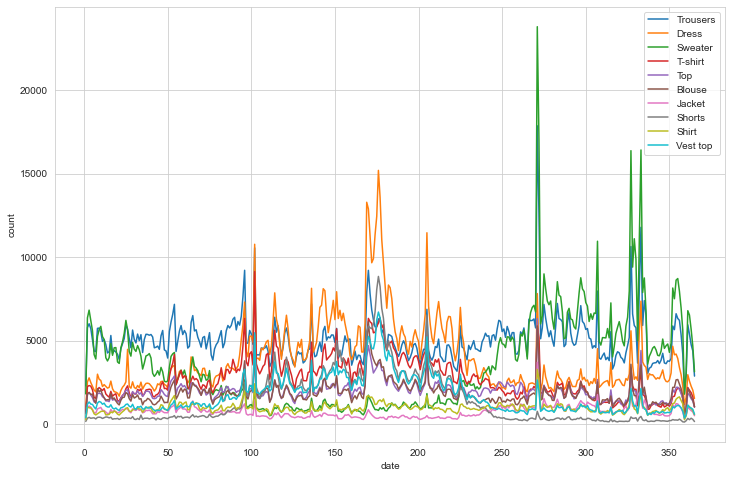

In [191]:
plt.figure(figsize = (12,8))

for prod in bestsellers[:10]:
    sns.lineplot(
        x=daily_counts.loc[pd.IndexSlice[:, prod],:].index.get_level_values(0),
        y='count', 
        data=daily_counts.loc[pd.IndexSlice[:, prod],:],
        label=prod
     )
    
plt.legend()

So we can see a few products have slightly different seasonal trends with sweaters, trousers and jackets more popular in the winter months and dresses and t-shirts more popular in Summer...which we probably could have guessed but it's good to verify and make sure we test any of our assumptions.

Finally, we'll look at the purchasing patterns by age demographic. Does the type of product purchased vary depending on the customer age?

In [199]:
with driver.session() as session:

    
    query1 = """
    MATCH (p:Product)-[:SUBSET_OF]->(n:ProductType) 
    WITH id(n) as top_products, COUNT(p) as count_prods ORDER BY COUNT(p) DESC LIMIT 30
    WITH collect(top_products) as top_30
    MATCH (a:AgeGroup)<-[:IS_AGE_GROUP]-(:Customer)-[pur:PURCHASED]->(:Product)-[:SUBSET_OF]->(pt:ProductType) WHERE id(pt) IN top_30 
    RETURN a.lower as lower, a.upper as upper, COUNT(pur) as total_purchases
    """
    
    total_by_age = list(session.run(query1))
    print('Query 1 Done')
    
    query2 = """
    MATCH (p:Product)-[:SUBSET_OF]->(n:ProductType) 
    WITH id(n) as top_products, COUNT(p) as count_prods ORDER BY COUNT(p) DESC LIMIT 30
    WITH collect(top_products) as top_30
    MATCH (a:AgeGroup)<-[:IS_AGE_GROUP]-(:Customer)-[pur:PURCHASED]->(:Product)-[:SUBSET_OF]->(pt:ProductType) WHERE id(pt) IN top_30
    WITH a.lower as lower, a.upper as upper, pur, pt.name as product_type
      RETURN 
        lower,
        upper,
        product_type, 
        COUNT(pur) as num_prod_purchases
    """
    print('Query 2 Done')
    
    
    total_by_age_product = list(session.run(query2))
    
# df = pd.DataFrame([dict(record) for record in data])


Query 1 Done
Query 2 Done


In [204]:
# Join the two dataframes and calculate the proportions
df_total = pd.DataFrame([dict(record) for record in total_by_age])
df_prod = pd.DataFrame([dict(record) for record in total_by_age_product])
df_all = pd.merge(df_total, df_prod, how='inner', on=['lower', 'upper'])
df_all['prod_proportion'] = df_all['num_prod_purchases'] / df_all['total_purchases']

In [211]:
# Pivot the dataframe so it can be plotted as a heatmap
df_pivot = pd.pivot(df_all, 'lower', 'product_type', 'prod_proportion')

<AxesSubplot:xlabel='lower', ylabel='product_type'>

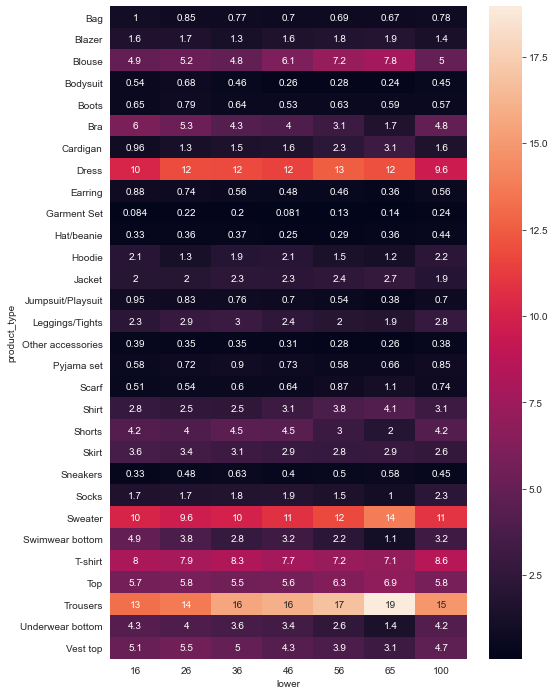

In [225]:
plt.figure(figsize = (8,12))
sns.heatmap(df_pivot.T*100, annot=df_pivot.T.values*100)